In [ ]:
# @title Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Import Libraries
import xarray as xr
import numpy as np
import pandas as pd
import joblib

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# You may import additional libraries if needed

# Aesthetics
sns.set_theme(style="whitegrid")
plt.rc('axes', titlesize=10, labelsize=9)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

In [ ]:
# @title Loading Data
merged_datasets = joblib.load("/content/drive/MyDrive/MastersProject/Data/aiwp_ml_setup_500geopotential_32x64_2020_leadtime72.pkl")
print(f"Merged_datasets size:{merged_datasets.shape} ")
merged_datasets.head()

Merged_datasets size:(1499136, 9) 


,time,longitude,latitude,graphcast,pangu,neuralgcm,keisler,ifshres,area_weight
0,2020-01-04,0.0,-87.1875,49969.980469,49928.015625,50061.421875,50178.781250,50103.640625,0.049068
1,2020-01-04,0.0,-81.5625,50197.351562,50232.875000,50227.707031,50329.074219,50357.289062,0.146730
2,2020-01-04,0.0,-75.9375,50326.664062,50367.367188,50305.351562,50443.339844,50433.640625,0.242980
3,2020-01-04,0.0,-70.3125,50008.304688,50005.089844,49969.562500,50070.718750,50055.031250,0.336890
4,2020-01-04,0.0,-64.6875,49281.628906,49232.839844,49214.851562,49260.562500,49303.812500,0.427555


In [ ]:
era5_dataset = joblib.load("/content/drive/MyDrive/MastersProject/Data/era5_ml_setup_500geopotential_32x64_2020.pkl")
print(f"era5_dataset size:{era5_dataset.shape} ")
era5_dataset.head()

era5_dataset size:(1556480, 5) 


,time,longitude,latitude,era5,area_weight
0,2020-01-01,0.0,-87.1875,49846.941406,0.049068
1,2020-01-01,0.0,-81.5625,50196.523438,0.146730
2,2020-01-01,0.0,-75.9375,50391.101562,0.242980
3,2020-01-01,0.0,-70.3125,49667.398438,0.336890
4,2020-01-01,0.0,-64.6875,49277.945312,0.427555


In [ ]:
# @title Merge Forecasts and Era5

#merged_datasets = merged_datasets.rename(columns={col: col + "_lt72" for col in merged_datasets.columns if col not in ["time", "longitude", "latitude"]})
df = era5_dataset.merge(merged_datasets, on=["time", "longitude", "latitude"], how="outer")

print(f"Dataframe size: {df.shape}")
df.head()

Dataframe size: (1556480, 11)


,time,longitude,latitude,era5,area_weight_x,graphcast,pangu,neuralgcm,keisler,ifshres,area_weight_y
0,2020-01-01,0.0,-87.1875,49846.941406,0.049068,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0.0,-81.5625,50196.523438,0.146730,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,0.0,-75.9375,50391.101562,0.242980,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,0.0,-70.3125,49667.398438,0.336890,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,0.0,-64.6875,49277.945312,0.427555,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate RMSE to compare to values on [WB2 website](https://sites.research.google/weatherbench/deterministic-scores/)



In [ ]:
def calculate_pairwise_rmse(df, columns):
    """Calculates the pairwise RMSE between specified columns in a DataFrame.

    Args:
      df: The input DataFrame.
      columns: A list of column names to calculate RMSE for.

    Returns:
      A pandas DataFrame representing the pairwise RMSE matrix.
    """

    n = len(columns)
    rmse_matrix = pd.DataFrame(index=columns, columns=columns)

    for i in range(n):
      for j in range(i, n):  # Only calculate upper triangle, as it is symmetric
          col1 = columns[i]
          col2 = columns[j]

          rmse = np.sqrt(((df[col1] - df[col2])**2 * df["area_weight_x"]).mean() / df["area_weight_x"].mean())
          rmse_matrix.loc[col1, col2] = rmse
          rmse_matrix.loc[col2, col1] = rmse # Assign to the lower triangle as well

    return rmse_matrix



In [ ]:
columns_to_calculate = [ 'era5','graphcast', 'pangu', 'neuralgcm', 'keisler','ifshres']
pairwise_rmse_result = calculate_pairwise_rmse(df, columns_to_calculate)
pairwise_rmse_result

,era5,graphcast,pangu,neuralgcm,keisler,ifshres
era5,0.0,115.160156,125.908476,104.454006,161.097318,124.894767
graphcast,115.160156,0.0,105.998268,102.279047,146.296251,113.080117
pangu,125.908476,105.998268,0.0,104.273869,140.367023,119.072937
neuralgcm,104.454006,102.279047,104.273869,0.0,129.467783,111.085068
keisler,161.097318,146.296251,140.367023,129.467783,0.0,163.773144
ifshres,124.894767,113.080117,119.072937,111.085068,163.773144,0.0


In [ ]:
#convert datatype object to float
pairwise_rmse_result = pairwise_rmse_result.apply(pd.to_numeric, errors='coerce')
# Create a mask for the upper triangle excluding the main diagonal
mask = np.triu(np.ones_like(pairwise_rmse_result, dtype=bool),k=1)

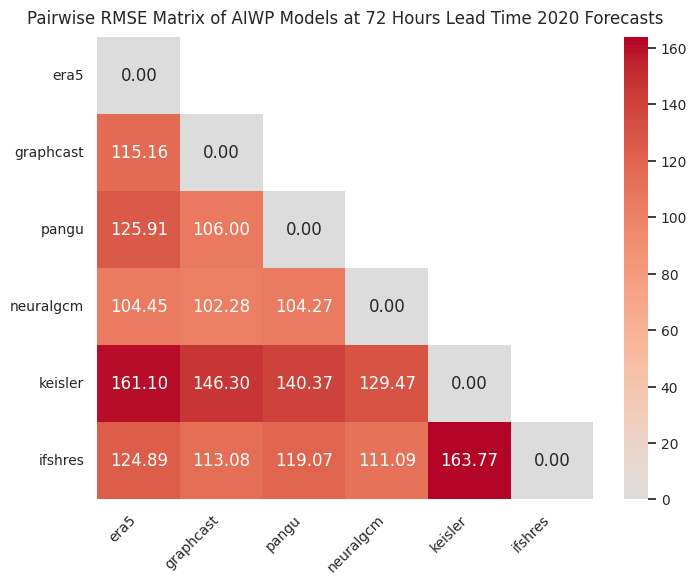

In [ ]:
# plot the heatmap

plt.rc('axes', titlesize=12, labelsize=9)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.figure(figsize=(8,6))
sns.heatmap(pairwise_rmse_result,mask=mask, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Pairwise RMSE Matrix of AIWP Models at 72 Hours Lead Time 2020 Forecasts', pad=10)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45° and align right
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.grid(False)
plt.savefig(f'/content/drive/MyDrive/MastersProject/Plots/Pairwise RMSE Matrix of AIWP Models at 72 Hours Lead Time 2020 Forecasts.pdf', dpi=300, bbox_inches="tight")

plt.show()

Do they equal RMSE of 115? Yes they do! ✅

In [ ]:
[pairwise_rmse_result.index]

[Index(['era5', 'graphcast', 'pangu', 'neuralgcm', 'keisler', 'ifshres'], dtype='object')]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Convert the filtered DataFrame to a NumPy array
distance_matrix = pairwise_rmse_result.values

# Apply MDS using the precomputed distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distance_matrix)

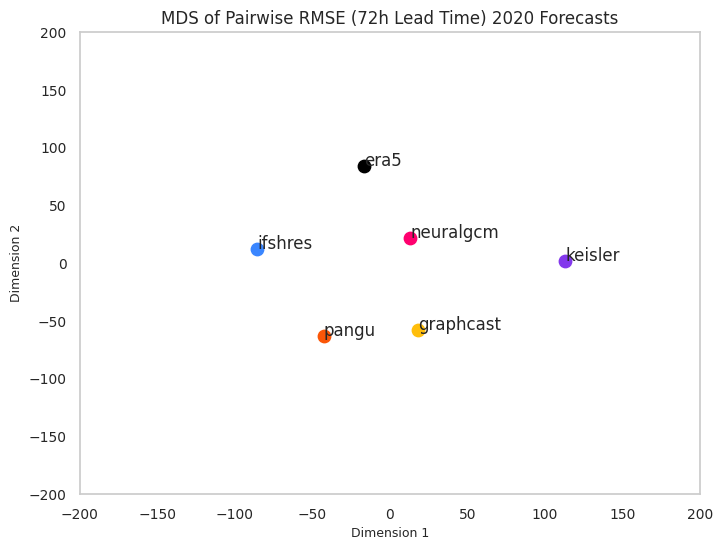

In [ ]:
color_dict = {
    "graphcast": "#ffbe0b",
    "pangu": "#fb5607",
    "neuralgcm": "#ff006e",
    "keisler": "#8338ec",
    "ifshres": "#3a86ff"
}

plt.figure(figsize=(8, 6))

for i, label in enumerate(pairwise_rmse_result.index):
    # Use black for ERA5, otherwise find the first matching key in color_dict
    dataset_color = 'black' if 'era5' in label else next((color for key, color in color_dict.items() if key in label), None)
    if dataset_color is None:
        continue
    plt.scatter(coords[i, 0], coords[i, 1], color=dataset_color, edgecolors=dataset_color, alpha=1, s=80)
    plt.annotate(label, (coords[i, 0], coords[i, 1]))

plt.title('MDS of Pairwise RMSE (72h Lead Time) 2020 Forecasts')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim([-200, 200])
plt.ylim([-200, 200])
plt.grid(False)
plt.savefig(f'/content/drive/MyDrive/MastersProject/Plots/MDS of Pairwise RMSE (72h Lead Time) 2020 Forecasts.pdf', dpi=300, bbox_inches="tight")
plt.show()
